# Prototyping the Class-Based Refactor for HMM

* Gaussian HMM
* Poisson HMM

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import jax.experimental.optimizers as optimizers
import jax.random as jr
import jax.numpy as np
from jax import jit, value_and_grad
from tqdm.auto import trange
import matplotlib.pyplot as plt

from ssm.models.hmm import make_gaussian_hmm
from ssm.plots import gradient_cmap
from ssm.utils import find_permutation
from tqdm.auto import trange
import warnings

import seaborn as sns
sns.set_style("white")
sns.set_context("talk")

color_names = [
    "windows blue",
    "red",
    "amber",
    "faded green",
    "dusty purple",
    "orange"
    ]

colors = sns.xkcd_palette(color_names)
cmap = gradient_cmap(colors)

def plot_transition_matrix(transition_matrix):
    plt.imshow(transition_matrix, vmin=0, vmax=1, cmap="Greys")
    plt.xlabel("next state")
    plt.ylabel("current state")
    plt.colorbar()
    plt.show()


def plot_hmm_data(obs, states):
    lim = 1.01 * abs(obs).max()
    time_bins, obs_dim = obs.shape
    plt.figure(figsize=(8, 3))
    plt.imshow(states[None,:],
            aspect="auto",
            cmap=cmap,
            vmin=0,
            vmax=len(colors)-1,
            extent=(0, time_bins, -lim, (obs_dim)*lim))

    for d in range(obs_dim):
        plt.plot(obs[:,d] + lim * d, '-k')

    plt.xlim(0, time_bins)
    plt.xlabel("time")
    plt.yticks(lim * np.arange(obs_dim), ["$x_{}$".format(d+1) for d in range(obs_dim)])

    plt.title("Simulated data from an HMM")

    plt.tight_layout()

In [4]:
latent_dim = 3
observation_dim = 2
transition_matrix = 0.9 * np.eye(latent_dim) \
                    + 0.1 * np.roll(np.eye(latent_dim), 1, axis=1)
emission_means = np.arange(6, dtype=float).reshape((3, 2)) - 3

true_hmm = make_gaussian_hmm(
    num_states=latent_dim, 
    emission_dim=observation_dim,
    transition_matrix=transition_matrix,
    emission_means=emission_means,
    emission_scale_trils=0.25 * np.eye(observation_dim))

num_timesteps = 100
num_trials = 100

all_states, all_data = [], []

rng = jr.PRNGKey(0)
v_all_states, v_all_data = true_hmm.sample(rng, num_timesteps, num_samples=num_trials)

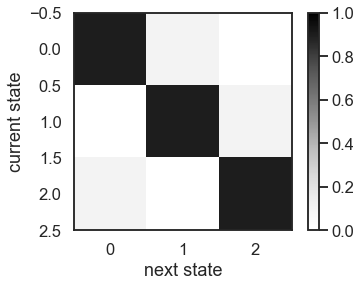

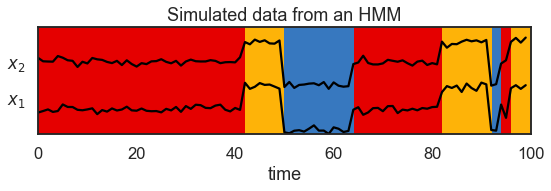

In [6]:
plot_transition_matrix(transition_matrix)
plot_hmm_data(v_all_data[0], v_all_states[0])

## Fit HMM using EM

In [7]:
seed = jr.PRNGKey(1)
learning_rate = 0.05

num_states_est = 3
emission_means = 3 * jr.normal(seed, shape=(num_states_est, 2))
hmm = make_gaussian_hmm(num_states_est, 2, 
                        transition_logits=np.zeros((num_states_est, num_states_est)), 
                        emission_means=emission_means)

[converged] LP: -40.929:   9%|▉         | 9/100 [00:06<01:03,  1.43it/s]


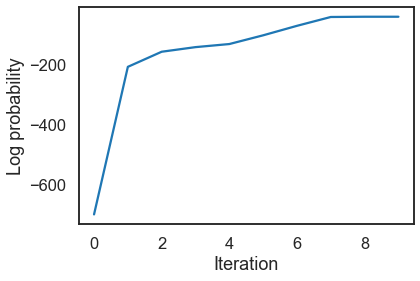

In [8]:
log_probs, fitted_hmm, posterior = hmm.fit(v_all_data, method="em", tol=1e-5)

plt.plot(log_probs)
plt.ylabel("Log probability")
plt.xlabel("Iteration")
plt.show()

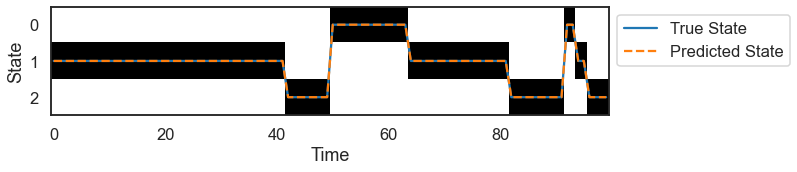

In [12]:
trial_idx = 0

Ez = posterior.expected_states[trial_idx]
perm = find_permutation(v_all_states[trial_idx], np.argmax(Ez, axis=-1))

plt.figure(figsize=(10, 2))
plt.imshow(Ez.T[perm, :], aspect="auto", interpolation="none", vmin=0, vmax=1, cmap="Greys")
plt.plot(v_all_states[trial_idx], '-', label="True State")
plt.plot(Ez.T[perm, :].argmax(axis=0), '--', label="Predicted State")
plt.legend(bbox_to_anchor=(1,1))
plt.xlabel("Time")
plt.ylabel("State")
plt.show()

# Poisson HMM

In [13]:
from ssm.models.hmm import make_poisson_hmm, initialize_poisson_hmm
import tensorflow_probability.substrates.jax as tfp

In [14]:
num_states = 5
num_channels = 10
transition_matrix = 0.90 * np.eye(num_states) + 0.10 * np.ones((num_states, num_states))
emission_rates = np.arange(0, num_states * num_channels, dtype=np.float32).reshape((num_states, num_channels))
emission_rates += 1

poisson_hmm = make_poisson_hmm(num_states, num_channels, transition_matrix=transition_matrix, emission_log_rates=np.log(emission_rates))

time_steps = 1000
num_trials = 100

rng = jr.PRNGKey(0)
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", "Explicitly requested dtype")
    v_all_states, v_all_data = poisson_hmm.sample(rng, time_steps, num_samples=num_trials)

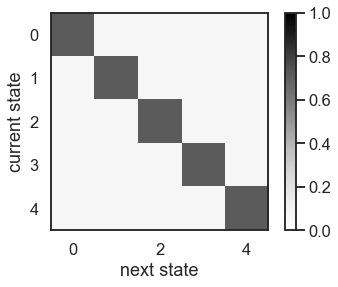

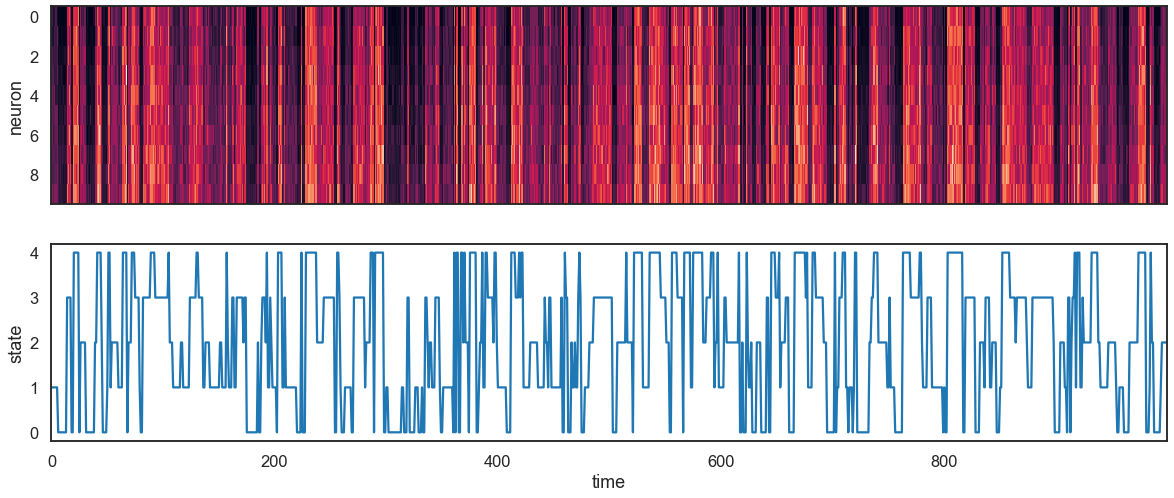

In [15]:
plot_transition_matrix(poisson_hmm.transition_matrix)

fig, axs = plt.subplots(2, 1, sharex=True, figsize=(20, 8))
axs[0].imshow(v_all_data[0].T, aspect="auto", interpolation="none")
axs[0].set_ylabel("neuron")
axs[1].plot(v_all_states[0])
axs[1].set_xlabel("time")
axs[1].set_ylabel("state")
plt.show()

## Fit HMM using exact EM update

[converged] LP: -29922.939:  11%|█         | 11/100 [00:05<00:41,  2.14it/s]


Text(0, 0.5, 'log likelihood')

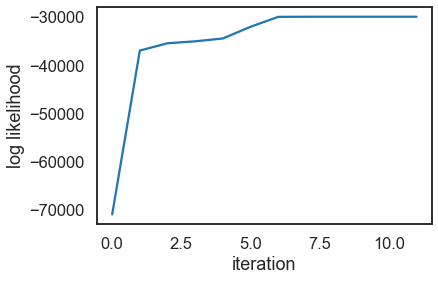

In [17]:
test_hmm = initialize_poisson_hmm(jr.PRNGKey(1), num_states, v_all_data[0])
lps, test_hmm, posterior = test_hmm.fit(v_all_data, method="em")

# Plot the log probabilities
plt.plot(lps)
plt.xlabel("iteration")
plt.ylabel("log likelihood")

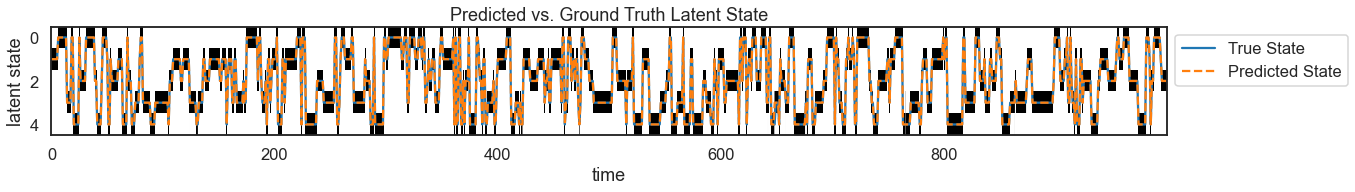

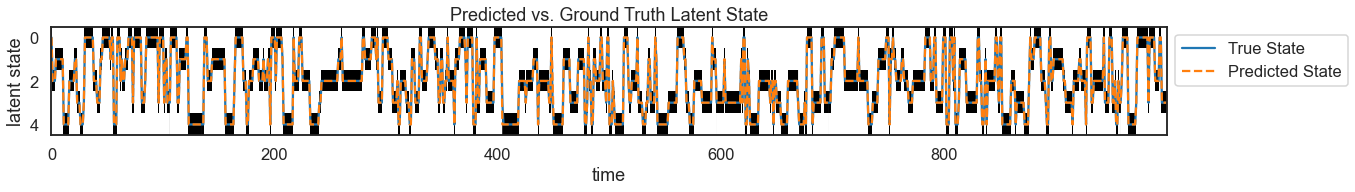

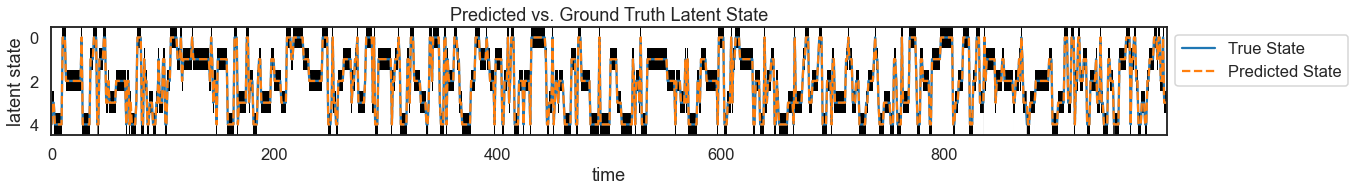

In [21]:
for trial_idx in range(3):
    Ez = posterior.expected_states[trial_idx]
    states = v_all_states[trial_idx]
    perm = find_permutation(v_all_states[trial_idx], np.argmax(Ez, axis=-1))

    # Posterior distribution
    plt.figure(figsize=(20, 2))
    plt.imshow(Ez.T[perm], aspect="auto", interpolation="none", cmap="Greys")
    plt.plot(states, label="True State")
    plt.plot(Ez.T[perm].argmax(axis=0), '--', label="Predicted State")
    plt.xlabel("time")
    plt.ylabel("latent state")
    plt.legend(bbox_to_anchor=(1,1))
    plt.title("Predicted vs. Ground Truth Latent State")
    plt.show()